# Определение возраста покупателей

## Фабула проекта

**Заказчик**: Сетевой супермаркет «Хлеб-Соль». Внедряют систему компьютерного зрения для обработки фотографий покупателей.

**Данные**: датасет, сформированный на основании открытых баз фотографий людей разных возрастов с сайта http://chalearnlap.cvc.uab.es/dataset/26/description/

**Задачи проекта**: обучить модель на основании фотофиксации покупателей в прикассовой зоне и обработки фотографий покупателей, опрелелять их возраст.

**Цели обучения**:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- Контролировать добросовестность кассиров при продаже алкоголя

**Дополнительные условия**: значением метрики MAE не более 8

**План проекта**:
 - Шаг 1. Исследовательский анализ данных
 - Шаг 2. Обучение модели
 - Шаг 3. Анализ обученной модели

## Исследовательский анализ данных

### Подготовка

#### Импорт библиотек

In [ ]:
pip list # изучим список установленных библиотек

Package                           Version
--------------------------------- -------------------
absl-py                           1.2.0
alembic                           1.6.5
anyio                             3.2.1
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.9.3
bleach                            3.3.0
blinker                           1.4
blis                              0.7.8
branca                            0.5.0
brotlipy                          0.7.0
cachetools                        5.2.0
catalogue                         2.0.8
catboost                          1.0.3
certifi                           2022.6.15
certipy                           0.1.3
cffi                              1.14.5
chardet             

In [ ]:
import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_colwidth', 1000)

In [ ]:
SEED = 42
FACES = '/datasets/faces/final_files'

#### Загрузка данных

In [ ]:
# подготовленная функция для загрузки данных в датафрейм
def data_load(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    else:
        try:
            response = requests.get(pth2)
            if response.status_code == 200:
                print("Запрос успешен. Загрузка данных...")
                return pd.read_csv(pth2)
            else:
                print(f"Ошибка: {response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Ошибка при запросе: {e}")

In [ ]:
labels = data_load(
    '/datasets/faces/labels.csv',
    'https://code.s3.yandex.net//datasets/faces/labels.csv'
)

In [ ]:
# инициализация загрузчика
datagen = ImageDataGenerator(rescale=1/255.)

# загрузка фотографий
datagen_flow = datagen.flow_from_dataframe(
    directory=FACES,
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=SEED)

features, target = next(datagen_flow)

Found 7591 validated image filenames.


### Анализ данных

#### Статистический анализ

In [ ]:
# используем ранее написанную функцию для изучения основной информации о датасетах
def data_info(data):
    print("=== ИНФОРМАЦИЯ О ДАННЫХ ===")
    print("\n\nРазмер выборки:")
    print(f"\nКоличество изображений: {data.shape[0]}")
    print(f"\nКоличество признаков: {data.shape[1]}")
    print("=" * 20)
    print("\nИнформация о датасете:")
    data.info() # вывод информации о датафрейме
    print("=" * 20)
    display(data.head()) # вывод верхнийх 5 строк датафрейма
    display(data.sample(5)) # вывод случайных 5 строк датафрейма
    display(data.tail()) # вывод нижних 5 строк датафрейма
    print("=" * 20)
    print("\nСтатистические данные:")
    display(data.describe().T) # вывод статистических показателей числовых значений датафрейма
    print("=" * 20)
    print("\nИнформация об аномалиях:")
    print("\nКоличество явных дубликатов: ", data.duplicated().sum()) # определение количества явных дубликатов строк
    print("Строки дубликаты:\n", data[data.duplicated()]) # вывод строк дубликатов, для их проверки
    print("=" * 20)
    print("Количество пропусков:\n", data.isna().sum()) # Вывод количества пропусков в датафрейме
    print("Доля пропусков в датафрейме:") # вывод информации о доле пропусков в датафрейме
    col = data.columns.tolist() # введем переменную со списком названий столбцов
    # циклом выведем долю пропусков в каждом столбце
    for a in col:
        print(f"В столбце {a} доля пропусков: {(data[a].isnull().sum() / len(data[a])*100).round(3)}%")

In [ ]:
data_info(labels)

=== ИНФОРМАЦИЯ О ДАННЫХ ===


Размер выборки:

Количество изображений: 7591

Количество признаков: 2

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
2996,002996.jpg,47
6879,006890.jpg,1
6740,006747.jpg,13
3509,003509.jpg,16
764,000764.jpg,16


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47



Статистические данные:


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0



Информация об аномалиях:

Количество явных дубликатов:  0
Строки дубликаты:
 Empty DataFrame
Columns: [file_name, real_age]
Index: []
Количество пропусков:
 file_name    0
real_age     0
dtype: int64
Доля пропусков в датафрейме:
В столбце file_name доля пропусков: 0.0%
В столбце real_age доля пропусков: 0.0%


#### Вывод

Полученный датафрейм состоит из 7591 записей в двух колонках:
 - в первой колонке названия файлов
 - во второй колонке возраст изображенного человека

Пропущенных данных в датафрейме нет, однако мы видим несоответствие названиям файлов и индексам - скорее всего по части изображениям людей нет информации о возрасте и по ним нет отметки в файле "labels"

Распределение возрастов построено следующим образом:
 - минимальный возраст 1 год
 - максимальный возраст 100 лет. Возможно так и есть но возможно это аномалия и ошибка. Согласно информации с сайта ChaLearn Looking at People в датабазе IMDBWIKI [34] распределение возрастов от 0 до 100. Если информация бралась из нее то максимум верный и это не ошибка.
 - среднее значение возраста 31, медианное 29, то есть основная масса распределения возрастов смещена в правую сторону - демографическое распределение таково, что общая масса представителей старше 29.
 - основная плоность возрастов распределена в диапазоне от 20 до 41 лет

#### Графический анализ

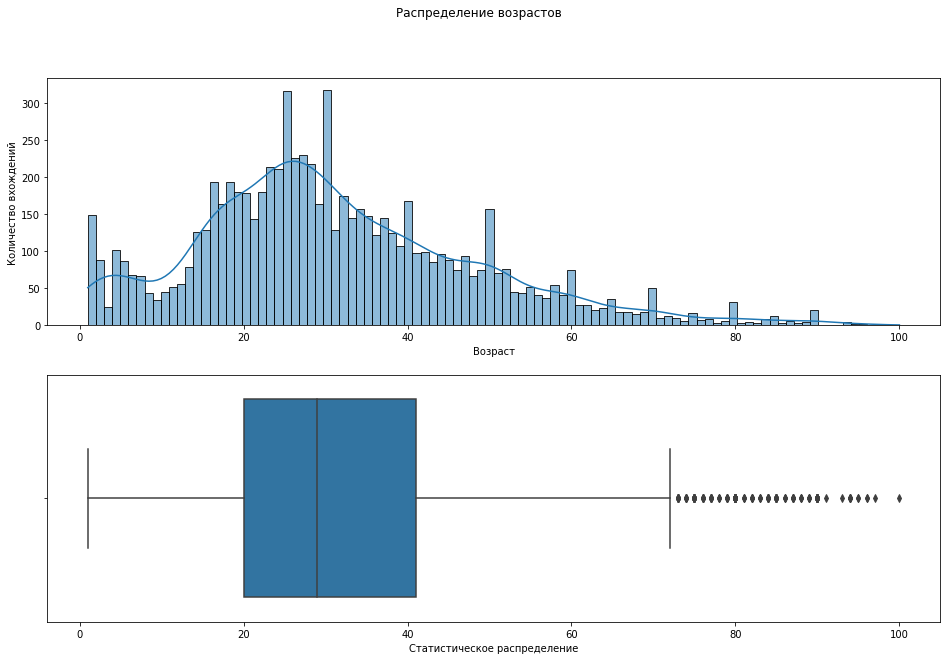

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))
fig.suptitle("Распределение возрастов")
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot (2, 1, 1)
sns.histplot(labels.real_age, kde=True, bins=100)
plt.xlabel("Возраст")
plt.ylabel("Количество вхождений")

plt.subplot (2, 1, 2)
sns.boxplot(x=labels.real_age)
plt.xlabel("Статистическое распределение")

plt.show()

#### Вывод

Как ранее уже было отмечено, основная масса фотографий распределена в диапазоне от 20 до 41 лет. Наблюдаем, что фотографии людей старше 70 единычные и представляют собой статистические выбросы. Однако это нормальная ситуация, так как после 70 чем больше возраст, тем сложнее найти представителя этого возраста и с повышением каждого года их все меньше и меньше, что и подтверждает гистограмма.

Видим, что у нас пик на возрасте 1 год, скорее всего это связанно с округлением в большую сторону младенцев младше 1 года, так как у нас отсутствует возрастная группа 0, хотя на сайте в датабазах часто распределение от 0. Также видим пики на возрасте 30 лет, 25 лет, и основных группах по 10ку: 40, 50, 60, 70, 80, 90.

#### Визуальный осмотр фотографий

In [ ]:
# Функция для просмотр примеров изображений
def sample_images(n_images=15):

    plt.figure(figsize=(15, 12))

    # Выбираем случайные изображения
    sample_indices = np.random.choice(len(labels), n_images, replace=False)

    for i, idx in enumerate(sample_indices):
        plt.subplot(3, 5, i+1)

        try:
            # Загружаем изображение
            img_path = f'/datasets/faces/final_files/{labels.iloc[idx]["file_name"]}'
            img = Image.open(img_path)

            # Отображаем изображение
            plt.imshow(img)
            plt.title(f'{labels.iloc[idx]["file_name"]}\nВозраст: {labels.iloc[idx]["real_age"]}\nРазмер: {img.size}\nРежим: {img.mode}')
            plt.axis('off')

        except Exception as e:
            print(f"Ошибка загрузки изображения {labels.iloc[idx]['file_name']}: {e}")
            plt.title(f'Ошибка загрузки\n{labels.iloc[idx]["file_name"]}')

    plt.tight_layout()
    plt.show()

Примеры изображений из датасета:


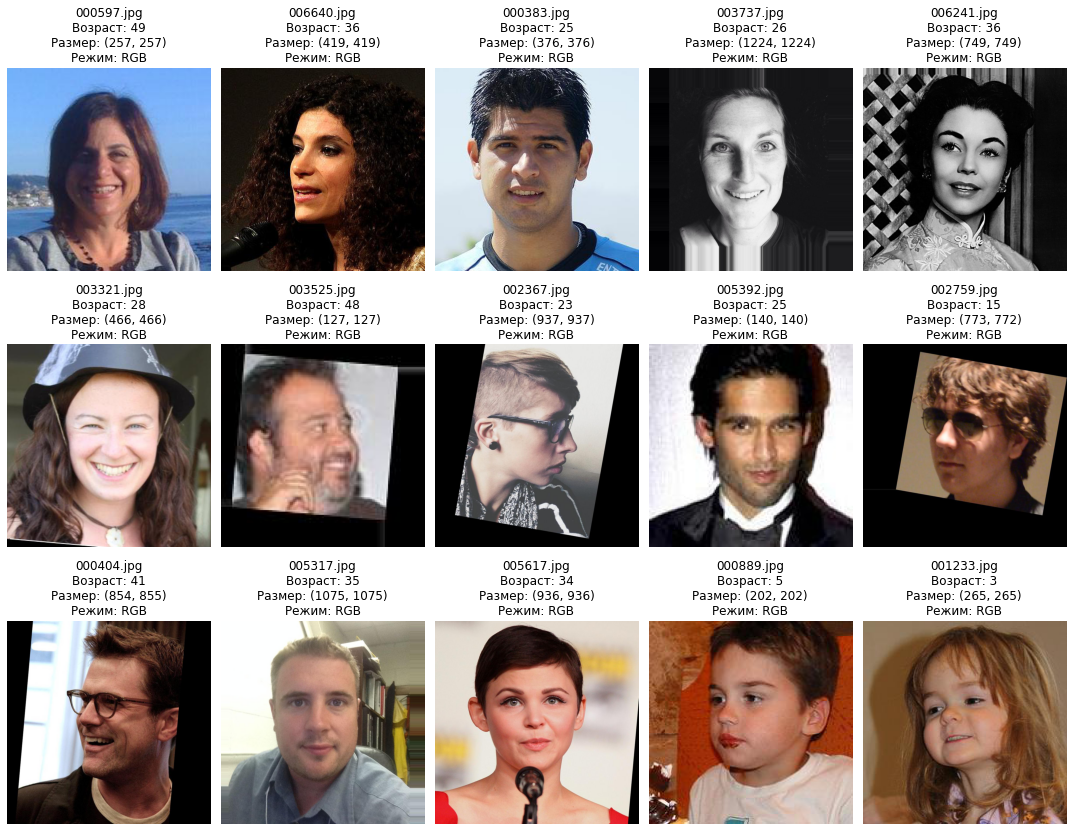

In [ ]:
# Отображаем примеры изображений
print("Примеры изображений из датасета:")
sample_images(15)

In [ ]:
# функция для анализа размеров изображений
def analyze_image_sizes(sample_size=100):

    widths = []
    heights = []

    # Берем выборку изображений для анализа размеров
    sample_indices = np.random.choice(len(labels), min(sample_size, len(labels)), replace=False)

    for idx in sample_indices:
        try:
            img_path = f'/datasets/faces/final_files/{labels.iloc[idx]["file_name"]}'
            img = Image.open(img_path)
            widths.append(img.size[0])
            heights.append(img.size[1])
        except:
            continue

    # Анализ размеров
    print(f"Проанализировано {len(widths)} изображений")
    print(f"Средняя ширина: {np.mean(widths):.2f} ± {np.std(widths):.2f}")
    print(f"Средняя высота: {np.mean(heights):.2f} ± {np.std(heights):.2f}")
    print(f"Минимальный размер: {min(widths)}x{min(heights)}")
    print(f"Максимальный размер: {max(widths)}x{max(heights)}")

In [ ]:
print("Анализ размеров изображений:")
analyze_image_sizes(700)

Анализ размеров изображений:
Проанализировано 700 изображений
Средняя ширина: 470.47 ± 361.18
Средняя высота: 471.04 ± 366.02
Минимальный размер: 57x56
Максимальный размер: 3666x3666


#### Вывод

Представленный датасет содержит фотографии разных людей разных возрастов, при этом фотографии имеют ряд нюансов, которые могут влиять на обучение:
 - в датасете содаржатся как цаетные, так и черно-белые фотографии
 - фотографии уже предобработанны таким образом, чтобы лицо распологалось вертикально, однако это создает пустые черные фотны на изображении
 - часть фотографий имеет артефакты частично скрывающие лицо - лишние предметы в виде головных уборов или очков, особенностей прически и т.п.
 - яркость и цветовая гамма изображений разная
 - на некоторых фотографиях фон занимает большую часть изображения, чем сам человек
 - на некоторых фотографиях присутствуют посторонние люди
 - некоторые фотографии имеют шумовое искажение

При этом размер фотографий имеет сильный разброс от 68x68 до 1757x1756, поэтому приведение к единому размеру для дальнейшего обучения это правильная практика, хотя это и повлияет на детализацию изображений.

### Вывод по блоку

Для исследовательского анализа данные о возрасте людей на фотографиях и фотографии были загружены, по ним проведен анализ.

В ходе статистического анализа установлено, что:
 - для исследования предоставлены 7591 фотография и столько же записей в таблице возрастов:
 - в предоставленных на исследование данных отсутствуют пропуски и аномалии
 - возраст людей, представленных на фотографиях распределен от 1 до 100 лет, основная плотность представленных фотографий по количеству экземпляров распределена в диапазоне от 20 до 41 лет, средний возраст представленных людей на фотографиях 31 год, медианный 29 лет. Такое распределени возрастов, позволит закрыть лишь маркетинговую цель обучения, так как для определения возраста покупателя при продаже алкоголя необходимо большее количество фотографий до 18 лет и в возрасте ближайшей к 18-летнему (хотя бы до 25).

В ходе графического анализа установлено, что:
 - распределение плтности возрастов подтвержено графичсеки
 - фотографии людей старше 70 единычные и представляют собой статистические выбросы. Однако это нормальная ситуация, так как после 70 чем больше возраст, тем сложнее найти представителя этого возраста и с повышением каждого года их все меньше и меньше, что и подтверждает гистограмма
 - имеются пиковые значения на возрасте 1 год, 25 и далее по 10ку: 40, 50, 60, 70, 80, 90.

В ходе визуального осмотра фотографий установлено, что:
 - фотографии предварительно подготовлены, лица людей на фотографиях расположены вертикально
 - все фотографии приведены к формату RGB, то есть содержат три слоя. При этом в датасете содержатся как цветные, так и черно-белые фотографии
 - в результате подготовки на многих фотграфиях есть артефакты в виде черных фонов, кроме того много фотграфий содержат и иные артефакты, условжняющие обучение
 - размер фотграфий имеет разброс от 68х68 до 1757x1756

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 15
SEED = 42

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=SEED
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='validation',
        seed=SEED
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=EPOCHS,
                 steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

```

Train for 89 steps, validate for 30 steps
Epoch 1/15
89/89 - 66s - loss: 198.8589 - mae: 10.4257 - val_loss: 585.3522 - val_mae: 19.1933
Epoch 2/15
89/89 - 42s - loss: 81.1975 - mae: 6.8236 - val_loss: 530.9394 - val_mae: 17.9828
Epoch 3/15
89/89 - 43s - loss: 50.9208 - mae: 5.4178 - val_loss: 485.4973 - val_mae: 16.9578
Epoch 4/15
89/89 - 42s - loss: 30.2611 - mae: 4.2038 - val_loss: 622.5557 - val_mae: 19.9045
Epoch 5/15
89/89 - 42s - loss: 20.2266 - mae: 3.4384 - val_loss: 497.3199 - val_mae: 17.1342
Epoch 6/15
89/89 - 42s - loss: 14.8758 - mae: 2.9834 - val_loss: 353.6137 - val_mae: 13.9160
Epoch 7/15
89/89 - 42s - loss: 12.4911 - mae: 2.7175 - val_loss: 175.2806 - val_mae: 10.0675
Epoch 8/15
89/89 - 42s - loss: 10.2324 - mae: 2.4509 - val_loss: 159.7014 - val_mae: 9.3506
Epoch 9/15
89/89 - 42s - loss: 9.4904 - mae: 2.3675 - val_loss: 97.7554 - val_mae: 7.5638
Epoch 10/15
89/89 - 42s - loss: 7.9910 - mae: 2.1604 - val_loss: 86.0162 - val_mae: 6.9192
Epoch 11/15
89/89 - 42s - loss: 6.5113 - mae: 1.9353 - val_loss: 75.3103 - val_mae: 6.5783
Epoch 12/15
89/89 - 42s - loss: 5.9394 - mae: 1.8506 - val_loss: 72.2179 - val_mae: 6.3962
Epoch 13/15
89/89 - 42s - loss: 6.9187 - mae: 1.9850 - val_loss: 80.0677 - val_mae: 6.9777
Epoch 14/15
89/89 - 42s - loss: 6.8136 - mae: 1.9609 - val_loss: 70.9951 - val_mae: 6.4279
Epoch 15/15
89/89 - 41s - loss: 6.4021 - mae: 1.9047 - val_loss: 66.3270 - val_mae: 6.2105

30/30 - 10s - loss: 66.3270 - mae: 6.2105

```

## Анализ обученной модели

По условиям задачи необходимо определять возраст человека изображенного на фотографии - задача линейной регрессии.

Для обучения использовалась предобученная нейросеть Resnet.

В ходе обучения нейросети:
 - слои с верхушки были исключены (include_top=False), а были самостоятельно сконструированы.
 - замораживание верхушки не производилось (backbone.trainable = False), поскольку данных в датасете достаточно для обучения.
 - тренировочная и валидационная выборки поделены в пропорции 4/1
 - для обучения модели была применена только одна аугментация (горизонтальный поворот), чтобы избежать чрезмерного времени обучения
 - при конструировании сети, использовался оптимизатор Adam, темп обучения выборан со значнеием 0.0005 - в два раза ниже стандартного значения, для большей стабильности при обучении
 - в соответствии с рекомендацией, в качестве функции потерь выбрана MSE, а в качестве метрики - MAE
 - для обучения выбрано среднее значение количества эпох, но допустимое с учетом скорости обучения - 15 эпох. Дальнейшее увеличение количества эпох изменяло бы итоговый результат незначительно - это заметно уже с 13 эпохи.

По итогу обучения получилось получить значения MSE на функции потерь в 66.32, а значение ключевой метрики MAE в 6.21, что хоть и ниже контрольного значения в 7, но все еще выше эталонного в 5.4. Для достижения эталонного значения, требуется большее количество экспериментов с параметрами и более тонкая настройка.

## Общий вывод

**Общий вывод**

По условиям задачи, для сетевого супермаркет «Хлеб-Соль», необходимо было обучить модель определения возраста покупателей по фотграфии в прикассовой зоне. Требования проекта - оценка MAE должна быть меньше 8.


**Этапы работы:**

1. Исследовательской анализ данных
2. Обучение модели
3. Анализ обученной модели

<h3>Исследовательской анализ данных</h3>

В ходе исследовательского анализа данных, информация о возрасте людей на фотографиях и фотографии были загружены, по ним проведен анализ.

В ходе статистического анализа установлено, что:
 - для исследования предоставлены 7591 фотография и столько же записей в таблице возрастов:
 - в предоставленных на исследование данных отсутствуют пропуски и аномалии
 - возраст людей, представленных на фотографиях распределен от 1 до 100 лет, основная плотность представленных фотографий по количеству экземпляров распределена в диапазоне от 20 до 41 лет, средний возраст представленных людей на фотографиях 31 год, медианный 29 лет. Такое распределени возрастов, позволит закрыть лишь маркетинговую цель обучения, так как для определения возраста покупателя при продаже алкоголя необходимо большее количество фотографий до 18 лет и в возрасте ближайшей к 18-летнему (хотя бы до 25).

В ходе графического анализа установлено, что:
 - распределение плтности возрастов подтвержено графичсеки
 - фотографии людей старше 70 единычные и представляют собой статистические выбросы. Однако это нормальная ситуация, так как после 70 чем больше возраст, тем сложнее найти представителя этого возраста и с повышением каждого года их все меньше и меньше, что и подтверждает гистограмма
 - имеются пиковые значения на возрасте 1 год, 25 и далее по 10ку: 40, 50, 60, 70, 80, 90.

В ходе визуального осмотра фотографий установлено, что:
 - фотографии предварительно подготовлены, лица людей на фотографиях расположены вертикально
 - все фотографии приведены к формату RGB, то есть содержат три слоя. При этом в датасете содержатся как цветные, так и черно-белые фотографии
 - в результате подготовки на многих фотграфиях есть артефакты в виде черных фонов, кроме того много фотграфий содержат и иные артефакты, условжняющие обучение
 - размер фотграфий имеет разброс от 68х68 до 1757x1756

<h3>Обучение модели и анализ</h3>

Для обучения модели использовалась предобученная нейросеть Resnet.

В ходе обучения нейросети:
 - слои с верхушки были исключены (include_top=False), а были самостоятельно сконструированы.
 - замораживание верхушки не производилось (backbone.trainable = False), поскольку данных в датасете достаточно для обучения.
 - тренировочная и валидационная выборки поделены в пропорции 4/1
 - для обучения модели была применена только одна аугментация (горизонтальный поворот), чтобы избежать чрезмерного времени обучения
 - при конструировании сети, использовался оптимизатор Adam, темп обучения выборан со значнеием 0.0005 - в два раза ниже стандартного значения, для большей стабильности при обучении
 - в соответствии с рекомендацией, в качестве функции потерь выбрана MSE, а в качестве метрики - MAE
 - для обучения выбрано среднее значение количества эпох, но допустимое с учетом скорости обучения - 15 эпох. Дальнейшее увеличение количества эпох изменяло бы итоговый результат незначительно - это заметно уже после 13 эпохи.

По итогу обучения получилось получить значения MSE на функции потерь в 66.32, а значение ключевой метрики MAE в 6.21, что хоть и ниже контрольного значения в 7, но все еще выше эталонного в 5.4. Для достижения эталонного значения, требуется большее количество экспериментов с параметрами и более тонкая настройка.

<h3>Рекомендации</h3>

Задача по обучению модели распознавания возраста покупателей по фотографии преследовала 2 цели:
 - Маркетинговая цель: анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
 - Цель безопасности: контроль добросовестность кассиров при продаже алкоголя

Из-за распределения возрастов в предоставленной для обучения выборки, текущая обученная модель больше всего подходит для первой, маркетинговой цели, но почти непригодня для второй.

Чтобы максимально качественно закрыть вторую цель, необходимо следующее:
 - задачу по определению возраста покупателей для контроля продажи алкогольной продукции выделить в самостоятельную задачу - задачу классификации (старше 18 лет/младше 18 лет)
 - для качественного обучения пересобрать выборку фотографий, чтобы основная плотность возрастных категорий была в диапазоне от 10 до 25 лет
 - обучить отдельную модель классификации, на основании этой выборки
 - разработать систему предупреждения, на основании обученной модели, которая будет сигнализировать о риске несоответствия покупателя возрастным критериям и сообщать эту информацию кассиру, для ручного контроля и сверки с паспортом, дублировать все инциденты сработки модели в службу безопасности супермаркета для последующего контроля качества работы кассиров